# Corrected overfitting issue

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from pandas.core.computation.check import NUMEXPR_INSTALLED

In [37]:
data = pd.read_excel("Extruder_model.xlsx")
data = data.sample(frac=1)
X_data = data.drop(["Energy(kJ/kg)" , "Torque(N.m)"],axis=1)
Y_data = data["Torque(N.m)"].values
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

In [38]:
data.describe()

,mass_flow(kg/h),screw_speed(rpm),solid_content(%),Energy(kJ/kg),Torque(N.m)
count,68.000000,68.000000,68.000000,68.000000,68.000000
mean,5.332647,988.235294,77.610294,7960.984037,5.404571
std,2.804795,154.078301,5.231289,5065.404788,2.038853
min,2.280000,800.000000,70.000000,2223.132691,2.604422
25%,2.280000,800.000000,72.500000,4319.000879,3.815900
50%,4.560000,1000.000000,77.500000,6556.696661,4.723950
75%,6.840000,1200.000000,82.500000,9921.835621,6.730930
max,13.680000,1200.000000,85.000000,26857.971178,10.582000


In [39]:
def grid_search(max_depths:list,n_estimators :list,cv:int =5):
    df = pd.DataFrame()
    for n_estimator in n_estimators:
    
        for md in max_depths:
            
            model_GradientBoostingRegressor= GradientBoostingRegressor( learning_rate=0.2, max_depth=md, n_estimators=n_estimator)
            cv_results = cross_validate(model_GradientBoostingRegressor,X_data,Y_data.reshape(-1,),cv=cv,scoring=('neg_mean_absolute_error'),return_train_score=True)
            for i in range(cv):
                df = pd.concat( [df,pd.DataFrame(data={"max_depth":md,"n_estimators" :n_estimator , "cv_result" :[-1*cv_results["train_score"][i]] , "type" : "train"})],axis =0)
            for i in range(cv):
                df = pd.concat( [df,pd.DataFrame(data={"max_depth":md,"n_estimators" :n_estimator , "cv_result" :[-1*cv_results["test_score"][i]] , "type" : "test"})],axis =0)

    
    return df

In [40]:
cv_gs_results = grid_search([1,2,3],[10,50,100,150,200,300],cv=10)
cv_gs_results.sort_values(["n_estimators","max_depth"],inplace=True)
cv_gs_results["md_nes"] = cv_gs_results.apply(lambda x:(x.max_depth , x.n_estimators),axis=1)

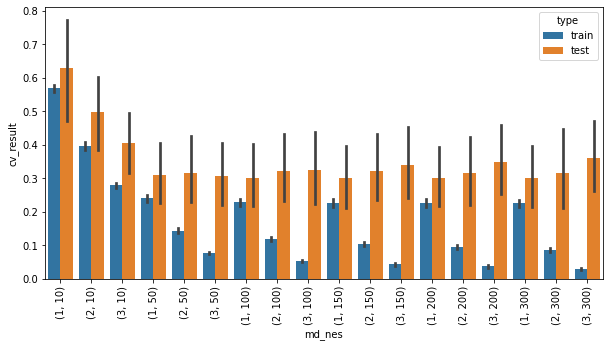

In [41]:
ax, fig  = plt.subplots(1,1,figsize = (10,5))
ax = sns.barplot(data=cv_gs_results , x =cv_gs_results["md_nes"] , y = "cv_result" ,hue = "type" )
ax.set_xticklabels(ax.get_xticklabels() ,rotation = 90);

In [42]:
df_plt = cv_gs_results.groupby(["md_nes", "type"],as_index=False).mean().drop(["max_depth" , "n_estimators"],axis=1)

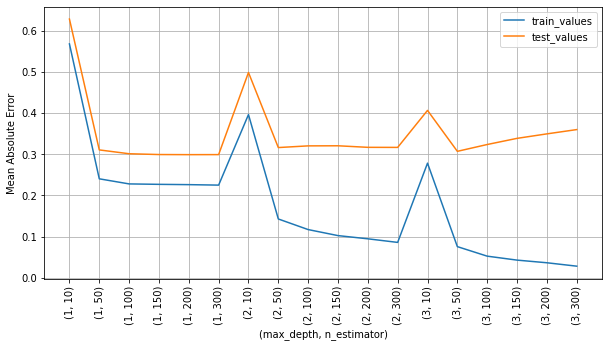

In [43]:
plt.figure(figsize=(10,5))
plt.plot(list(map(str,df_plt[df_plt["type"] == "train"].md_nes.values)),  list(df_plt[df_plt["type"] == "train"].cv_result.values),label = "train_values")
plt.plot(list(map(str,df_plt[df_plt["type"] == "test"].md_nes.values)),  list(df_plt[df_plt["type"] == "test"].cv_result.values),label = "test_values")
plt.xticks(rotation = 90)
plt.xlabel("(max_depth, n_estimator)")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(which = "both")

In [44]:
model_Torque= GradientBoostingRegressor( learning_rate=0.2, max_depth=1, n_estimators=100)
Torque = cross_validate(model_Torque,X_data,Y_data.reshape(-1,),cv=10,scoring=('neg_mean_absolute_error'),return_train_score=True)

In [45]:
print("test scores:\n",list(map(abs,Torque["test_score"])))
print("mean:  ",abs(np.mean(Torque["test_score"])) )
print("\n\n")
print("train scores:\n",list(map(abs,Torque["train_score"])))
print("mean:  ",abs(np.mean(Torque["train_score"]) ))


test scores:
 [0.25797910835616145, 0.18899839161898996, 0.46118194157822456, 0.23218353584614704, 0.4822877502247459, 0.2804735335934438, 0.12558297217412953, 0.5806013332363754, 0.15420664665498296, 0.2468965451866955]
mean:   0.3010391758469896



train scores:
 [0.24329472844060712, 0.24050158518586004, 0.20618550273779712, 0.23617570433245427, 0.21334629968654187, 0.22403028191442917, 0.2502305767018401, 0.19152125585523405, 0.23638181803467181, 0.236492822531513]
mean:   0.22781605754209483


In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)
model_Torque= GradientBoostingRegressor(learning_rate=0.2, max_depth=3, n_estimators=150)
model_Torque.fit(X_train,y_train)
y_pred=model_Torque.predict(X_test)

In [47]:
from joblib import dump, load
dump(model_Torque,'model_Torque.h5') 

['model_Torque.h5']

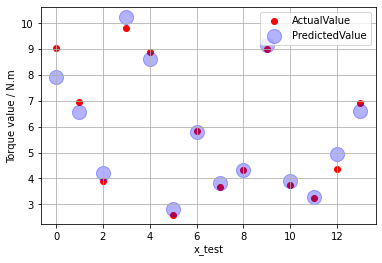

In [34]:
#plots
plt.scatter(list(range(len(y_pred))),y_test, c= ('red'))
plt.scatter(list(range(len(y_pred))),y_pred, c= ('blue'),alpha=0.3,s=200)
plt.xlabel('x_test')
plt.ylabel('Torque value / N.m')
plt.legend(['ActualValue', 'PredictedValue'])
plt.grid(which = "both")
plt.show()

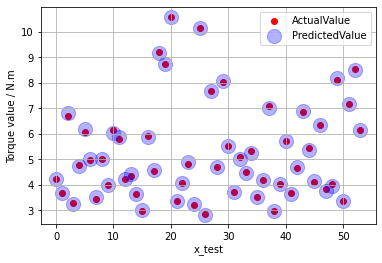

In [35]:
#plots
plt.scatter(list(range(len(y_train))),y_train, c= ('red'))
plt.scatter(list(range(len(y_train))),model_Torque.predict(X_train), c= ('blue'),alpha=0.3,s=200)
plt.xlabel('x_test')
plt.ylabel('Torque value / N.m')
plt.legend(['ActualValue', 'PredictedValue'])
plt.grid(which = "both")
plt.show()